In [26]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas  as pd
import numpy as np

In [27]:
DATASET_TO_USE = "ppi"

def get_ppi_dataset(emb_file):
    """
    returns a dataframe with embeddings and labels
    """
    # first row has the # of nodes and features
    emb_df = pd.read_csv(emb_file, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    lines = [line for line in open(LABELS_FILE).read().splitlines()]
    node_ids = [int(line.split()[0]) for line in lines]
    labels = [list(map(int, line.split()[1:])) for line in lines]
    input_df = pd.DataFrame({'node_id': node_ids, 'labels': labels})
    
    result_df = pd.merge(emb_df, input_df, on='node_id', how='inner')
    
    return result_df

def get_blog_dataset():
    # first row has the # of nodes and features
    emb_df = pd.read_csv(EMB_FILE, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    input_df = pd.read_csv(INPUT_FILE, header=None, names=["node_id", "label"])
    input_df_grouped = input_df.groupby(by=['node_id'])['label'].apply(list).reset_index(name ='labels')
    result_df = pd.merge(emb_df, input_df_grouped, on='node_id', how='inner')
    
    return result_df


if DATASET_TO_USE == "ppi":
    LABELS_FILE = "../data/PPI/ppi_labels.txt"
    emb_file = "../emb/ppi.emb"
    df = get_ppi_dataset(emb_file)
else:
    EMB_FILE = "../emb/seed_1_perc_0.5_blog_catalog.emb"
    LABELS_FILE = "../data/BlogCatalog/group-edges.csv"
    df = get_blog_dataset()

In [10]:
# Extend prediction function for the OVR logistic regression model
# This code is taken from https://github.com/Kombustor/submission-ecir2020-randomwalks/blob/submission/impl/model/classify.py#L11
class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        """
        return the labels with the highest k probabilities prediction, where k is the number of labels Y_test have
        """
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)

In [23]:
def evaluate(df, test_sizes, num_iter=10):
    evaluations_micro = []
    evaluations_macro = []

    Y = df['labels']
    X = df.drop(columns=['labels', 'node_id'])

    # binarize data
    binarizer = MultiLabelBinarizer()
    binarizer.fit(Y)

    # Linear regression uses L2 regularization by default
    ovr_lr =  OneVsRestClassifier(lr(solver='liblinear'))
    clf = TopKRanker(ovr_lr)

    for test_size in test_sizes:
        micro_scores = []
        macro_scores = []
        for x in range(num_iter):

            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

            Y_train = binarizer.transform(Y_train)

            top_k_list = [len(l) for l in Y_test]
            Y_test = binarizer.transform(Y_test)

            # evaluation
            clf.fit(X_train, Y_train)
            Y_pred = clf.predict(X_test, top_k_list=top_k_list)

            micro_scores.append(f1_score(Y_test, Y_pred, average='micro', zero_division=0))
            macro_scores.append(f1_score(Y_test, Y_pred, average='macro', zero_division=0))
        
        print(micro_scores)
        evaluations_micro.append((test_size, sum(micro_scores)/num_iter*100),)
        evaluations_macro.append((test_size, sum(macro_scores)/num_iter*100))
        print(f"Perc: {test_size}")
    return evaluations_micro, evaluations_macro

In [28]:
test_size_exp =  [x/10 for x in range(1, 10)]
test_size_exp = [0.5]
micro, macro = evaluate(df, test_size_exp, 5)

[0.21301247771836007, 0.21549636803874092, 0.21583383503913306, 0.2156441717791411, 0.21317474839890208]
Perc: 0.5


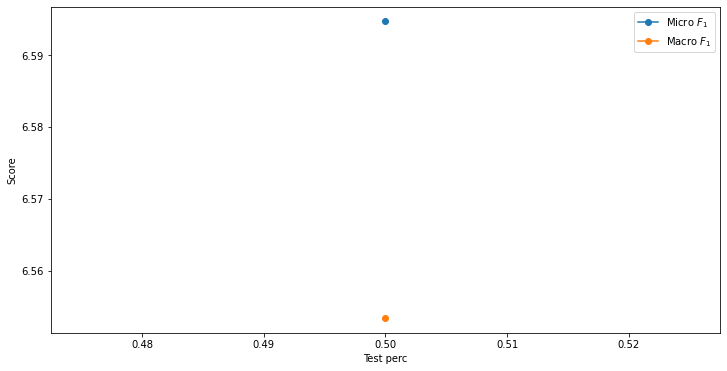

In [75]:
def plot_scores(micro, macro):
    fig, ax = plt.subplots(figsize=(12, 6))

    perc = [x[0] for x in micro]
    micro_score = [x[1] for x in micro]
    macro_score = [x[1] for x in macro]
    micro_score.reverse()
    macro_score.reverse()
    
    plt.plot(perc, micro_score, marker='o', label='Micro $F_1$')
    
    plt.plot(perc, macro_score, marker='o', label='Macro $F_1$')
        
        
    
    plt.xlabel("Test perc")
    plt.ylabel("Score")
    plt.legend(loc='best')
    plt.show()
    
plot_scores(micro, macro)

# Grid search for q and p

In [ ]:
import subprocess

grid = {
    'q': [0.25, 0.50, 1, 2, 4]
    'p': [0.25, 0.50, 1, 2, 4]
}

for p in grid['p']:
    for q in grid['q']:
    cmd = f"python main.py --p {p} --q {q} --input {INPUT_FILE} --output {DATASET_TO_USE}_q_{q}_p_{p}"
    
    if DATA_TO_USE == 'ppi':
        df = get_ppi_dataset(emb_file)
    
    subprocess.run(cmd, shell=True)
    evaluate()


    